# ML model 

Now that we have set up user creation and authentification, we need our main selling point - the machine learning model. We will create an ML model that outputs how likely is a person surviving after a heart attack given a set of features {cite}`heart_disease`.

The data source can be found here: https://www.kaggle.com/andrewmvd/heart-failure-clinical-data

# Python packages 

In [39]:
# Data wrangling 
import pandas as pd 

# Xgboost model 
import xgboost as xgb

# Directory traversal 
import os

# Classifier accuracy
from sklearn.metrics import roc_auc_score

# Ploting 
import matplotlib.pyplot as plt

# Train test split 
from sklearn.model_selection import train_test_split

# Array math 
import numpy as np 

# Model saving 
import pickle
import json

# Cross validation split 
from sklearn.model_selection import KFold

# Parameter grid creation 
from sklearn.model_selection import ParameterGrid

# Data input 

In [40]:
# Input data 
d = pd.read_csv('ML_API/ml_input/heart_failure_clinical_records_dataset.csv')
print(f"Shape of data: {d.shape}")

# Listing out the columns
print(f"Columns:\n{d.columns.values}")

# Printing out the head of data 
print(f"Head of data:\n{d.head()}")

Shape of data: (299, 13)
Columns:
['age' 'anaemia' 'creatinine_phosphokinase' 'diabetes' 'ejection_fraction'
 'high_blood_pressure' 'platelets' 'serum_creatinine' 'serum_sodium' 'sex'
 'smoking' 'time' 'DEATH_EVENT']
Head of data:
    age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0  75.0        0                       582         0                 20   
1  55.0        0                      7861         0                 38   
2  65.0        0                       146         0                 20   
3  50.0        1                       111         0                 20   
4  65.0        1                       160         1                 20   

   high_blood_pressure  platelets  serum_creatinine  serum_sodium  sex  \
0                    1  265000.00               1.9           130    1   
1                    0  263358.03               1.1           136    1   
2                    0  162000.00               1.3           129    1   
3                    0

## Collumn explanation

We will be using the following columns in our model:

**DEATH_EVENT** - `boolean` - whether the patient died or not after the heart attack.

**age** - `float` - age durring heart attack.

**anaemia** - `boolean` - decrease of red blood cells.

**creatinine_phosphokinase** - float - level of the CPK enzyme in the blood (mcg/L).

**diabetes** - `boolean` - whether the patient has diabetes or not.

**ejection_fraction** - `float` - percentage of blood leaving the heart at each contraction (percentage).

**high_blood_pressure** - `boolean` - whether the patient has high blood pressure or not.

**platelets** - `float` - platelets in the blood (kiloplatelets/mL)

**serum_creatinine** - `float` - serum creatinine level (mg/dL).

**serum_sodium** - `float` - serum sodium level (mEq/L).

**sex** - `boolean` - woman or man (binary).

**smoking** - `boolean` - whether the person smoked or not. 

In [41]:
# Defining the columns and saving for later 
y_var = 'DEATH_EVENT'

# Numerics 
numeric_columns = [
    'age', 
    'creatinine_phosphokinase',
    'ejection_fraction',
    'platelets',
    'serum_creatinine',
    'serum_sodium'
]

# Categoricals 
categorical_columns = [
    'anaemia',
    'diabetes',
    'high_blood_pressure',
    'sex',
    'smoking'
]

# EDA 

## Y variable distribution

Text(0.5, 1.0, 'Distribution of DEATH_EVENT')

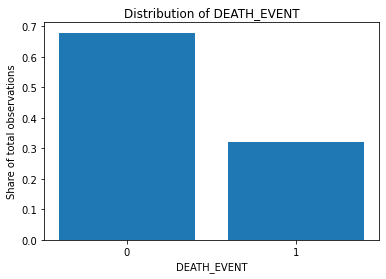

In [42]:
# Distribution of the binary variable
counts = d.groupby(y_var, as_index=False).size()
counts['distr'] = counts['size'] / counts['size'].sum()

# Visualizing the distribution 
plt.bar(counts['DEATH_EVENT'].astype(str), counts['distr'])
plt.xlabel("DEATH_EVENT")
plt.ylabel("Share of total observations")
plt.title("Distribution of DEATH_EVENT")


The Y variable classes are not perfectly balanced but we cannot say that they are extremely unbalanced as well (in some cases, one class observations comprise less than 1% of data). 

In our model, we will not be doing any artificial class balancing. 

## Numeric feature impact 

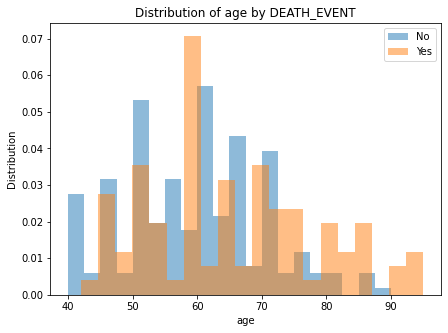

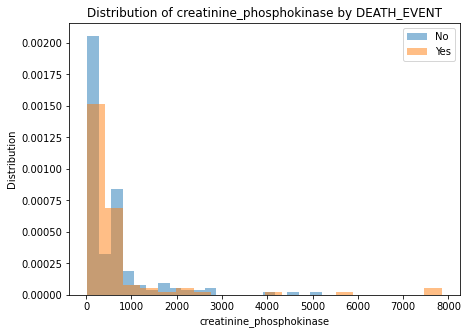

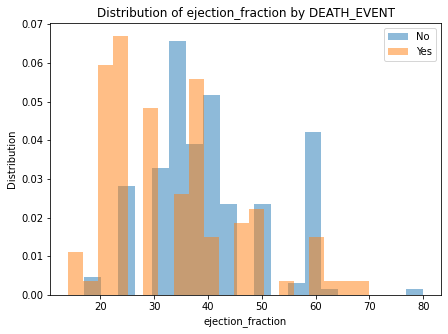

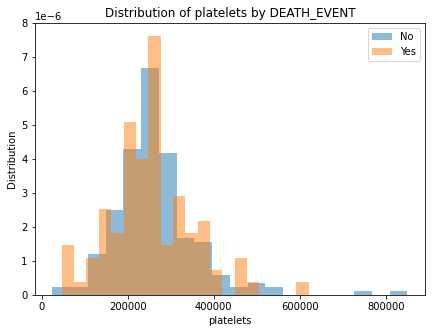

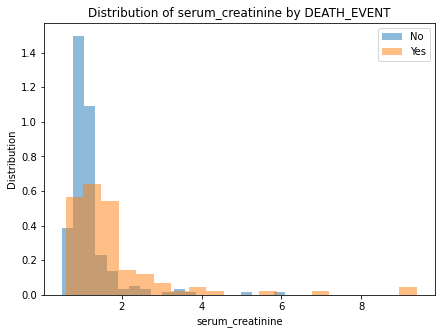

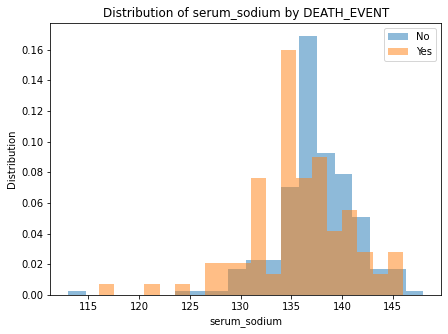

In [43]:
## Numeric feature impact 
for column in numeric_columns:
    plt.figure(figsize=(7, 5))
    plt.hist(d.loc[d[y_var] == 0, column], bins=20, alpha=0.5, label='No', density=True)
    plt.hist(d.loc[d[y_var] == 1, column], bins=20, alpha=0.5, label='Yes', density=True)

    plt.legend()
    plt.xlabel(column)
    plt.ylabel("Distribution")
    plt.title(f"Distribution of {column} by DEATH_EVENT")

There are no clear separation of classes in either of the numeric features. 

# Xgboost model 

We will do a 5 fold cross validation hyperparameter search in order to find the best XGB model. 

In [55]:
# Defining the final feature list 
final_features = numeric_columns + ['sex', 'high_blood_pressure']

# Defining a list of hyperparameters 
hp_dict = {
    'n_estimators': [30, 60, 120, 160], 
    'max_depth': [2, 3, 4, 5], 
    'learning_rate': [0.1, 0.2, 0.3],
    'eval_metric': ['logloss'],
    'use_label_encoder': [False],
    'min_child_weight': [0.5, 1]
}

# Creating the parameter grid 
param_grid = ParameterGrid(hp_dict)

# Initiating the empty placeholder for the AUC scores
auc_scores = []

# Iterating over the parameter grid
for params in param_grid:
    # Spliting the data into 5 folds 
    kf = KFold(n_splits=5, shuffle=True, random_state=3)

    # Initiating the empty placeholder for the scores
    auc_scores_folds = []

    # Iterating over the folds
    for train_index, test_index in kf.split(d):
        # Splitting the data into training and test sets
        train, test = d.iloc[train_index], d.iloc[test_index]
        
        train_X_fold, test_X_fold = train[final_features], test[final_features]
        train_y_fold, test_y_fold = train[y_var], test[y_var]

        # Creating the XGBoost model 
        model = xgb.XGBClassifier(**params)

        # Fitting the model 
        model.fit(train_X_fold, train_y_fold)

        # Predicting the test set 
        preds = model.predict_proba(test_X_fold)[:, 1]

        # Calculating the AUC score 
        auc_scores_folds.append(roc_auc_score(test_y_fold, preds))
    
    # Averaging the scores and appending to the master list 
    auc_scores.append(np.mean(auc_scores_folds))

# Creating the dataframe with the hyperparameters and AUC scores
df_scores = pd.DataFrame(param_grid)
df_scores['mean_auc'] = [round(x, 3) for x in auc_scores]

# Sorting by mean AUC score
df_scores = df_scores.sort_values('mean_auc', ascending=False)
df_scores.reset_index(drop=True, inplace=True)

# Printing the top 10 hyperparameters
print(f"Top 10 hyperparameters:\n{df_scores.head(10)}")

# Saving the best hyper parameters
best_hp = df_scores.iloc[0].to_dict()
del best_hp['mean_auc']

Top 10 hyperparameters:
  eval_metric  learning_rate  max_depth  min_child_weight  n_estimators  \
0     logloss            0.1          2               0.5            30   
1     logloss            0.1          5               1.0            30   
2     logloss            0.1          2               1.0            30   
3     logloss            0.1          4               1.0            30   
4     logloss            0.1          3               0.5            30   
5     logloss            0.1          3               1.0            30   
6     logloss            0.1          5               1.0            60   
7     logloss            0.2          2               1.0            30   
8     logloss            0.1          5               0.5            30   
9     logloss            0.1          4               0.5            30   

   use_label_encoder  mean_auc  
0              False    0.7756  
1              False    0.7739  
2              False    0.7705  
3              Fal

# Fitting the final model 

We will be using xgboost as our final model for this project. 

The final hyperparameters are the top ones from the K-FOLD analysis.

In [51]:
# X and Y for the model 
X, Y = d[final_features].copy(), d[y_var].values

# Fitting the model 
clf = xgb.XGBClassifier(**best_hp)
clf.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=2, min_child_weight=0.5, missing=nan,
              monotone_constraints='()', n_estimators=30, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

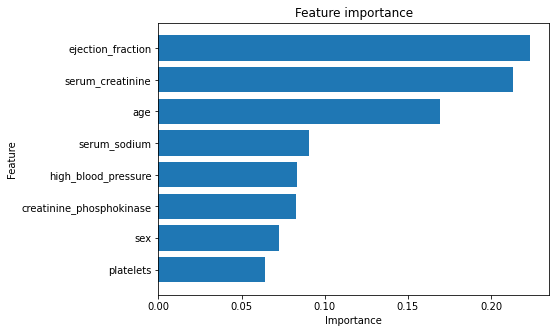

In [52]:
# Creating the feature importance frame 
feature_importance = pd.DataFrame({
    'feature': final_features,
    'importance': clf.feature_importances_
}).sort_values("importance", ascending=True)

# Ploting 
plt.figure(figsize=(7, 5))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.title("Feature importance")
plt.show()

## Saving all the necessary objects 

In order to successfuly serve the model, we need to save all the necessary objects. The objects are: 

* The model itself. 
* The input data schema. 

The input data schema will be saved as a dictionary in a JSON file with the following structure: 

```
{
    "input_schema": {
        "columns": [
            {
                "name": "column_name",
                "type": "float"
            },
            {
                "name": "column_name",
                "type": "float"
            },
            ...
        ]
    }
}
```

The model will be saved as a pickle file as well. 

In [53]:
# Creating the input schema
features = [] 
for col in X.columns:
    if col in numeric_columns:
        features.append({
            "name": col,
            "type": "numeric"
        })
    else:
        features.append({
            "name": col,
            "type": "boolean"
        })

input_schema = {
    "input_schema": {
        "columns": features
    }
}

# Creating the output dir 
output_dir = os.path.join("ML_API", "ml_model")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Saving the model to a pickle file 
with open(os.path.join(output_dir, "model.pkl"), "wb") as f:
    pickle.dump(clf, f)

# Saving the input schema 
with open(os.path.join(output_dir, "input_schema.json"), "w") as f:
    json.dump(input_schema, f) 

Now that we have these files, we can use them in our ML API. When serving machine learning, it is always a good practice to save the input schema as well as the model. The schema will be used to preprocess the incoming data from users and make it ingestable by the model.

In the next chapter, we will create more database models and endpoints to serve predictions from our model. 